# GaugePredict Data Downloader

This is a tool to download discharge data 

#### Download Packages

In [1]:
import os
os.chdir(r"C:\Users\cturn\Documents\CSDMS\GaugePredict\GaugePredict")
import sys
import json
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import cmocean 
import contextily as ctx
from dataretrieval import nwis
from GaugePredict.routines import plot_hucs
import GaugePredict.downloader_test
from GaugePredict.routines import compute_discharge_stats, plot_discharge_panels


Upload shape files:

Basin boundaries USGS: https://www.usgs.gov/national-hydrography/access-national-hydrography-products

You will want to download your basins of interest

Lets Look at all Hydrological Unit Code (HUC) Zones in the Continental United States (CONUS) and Alaska

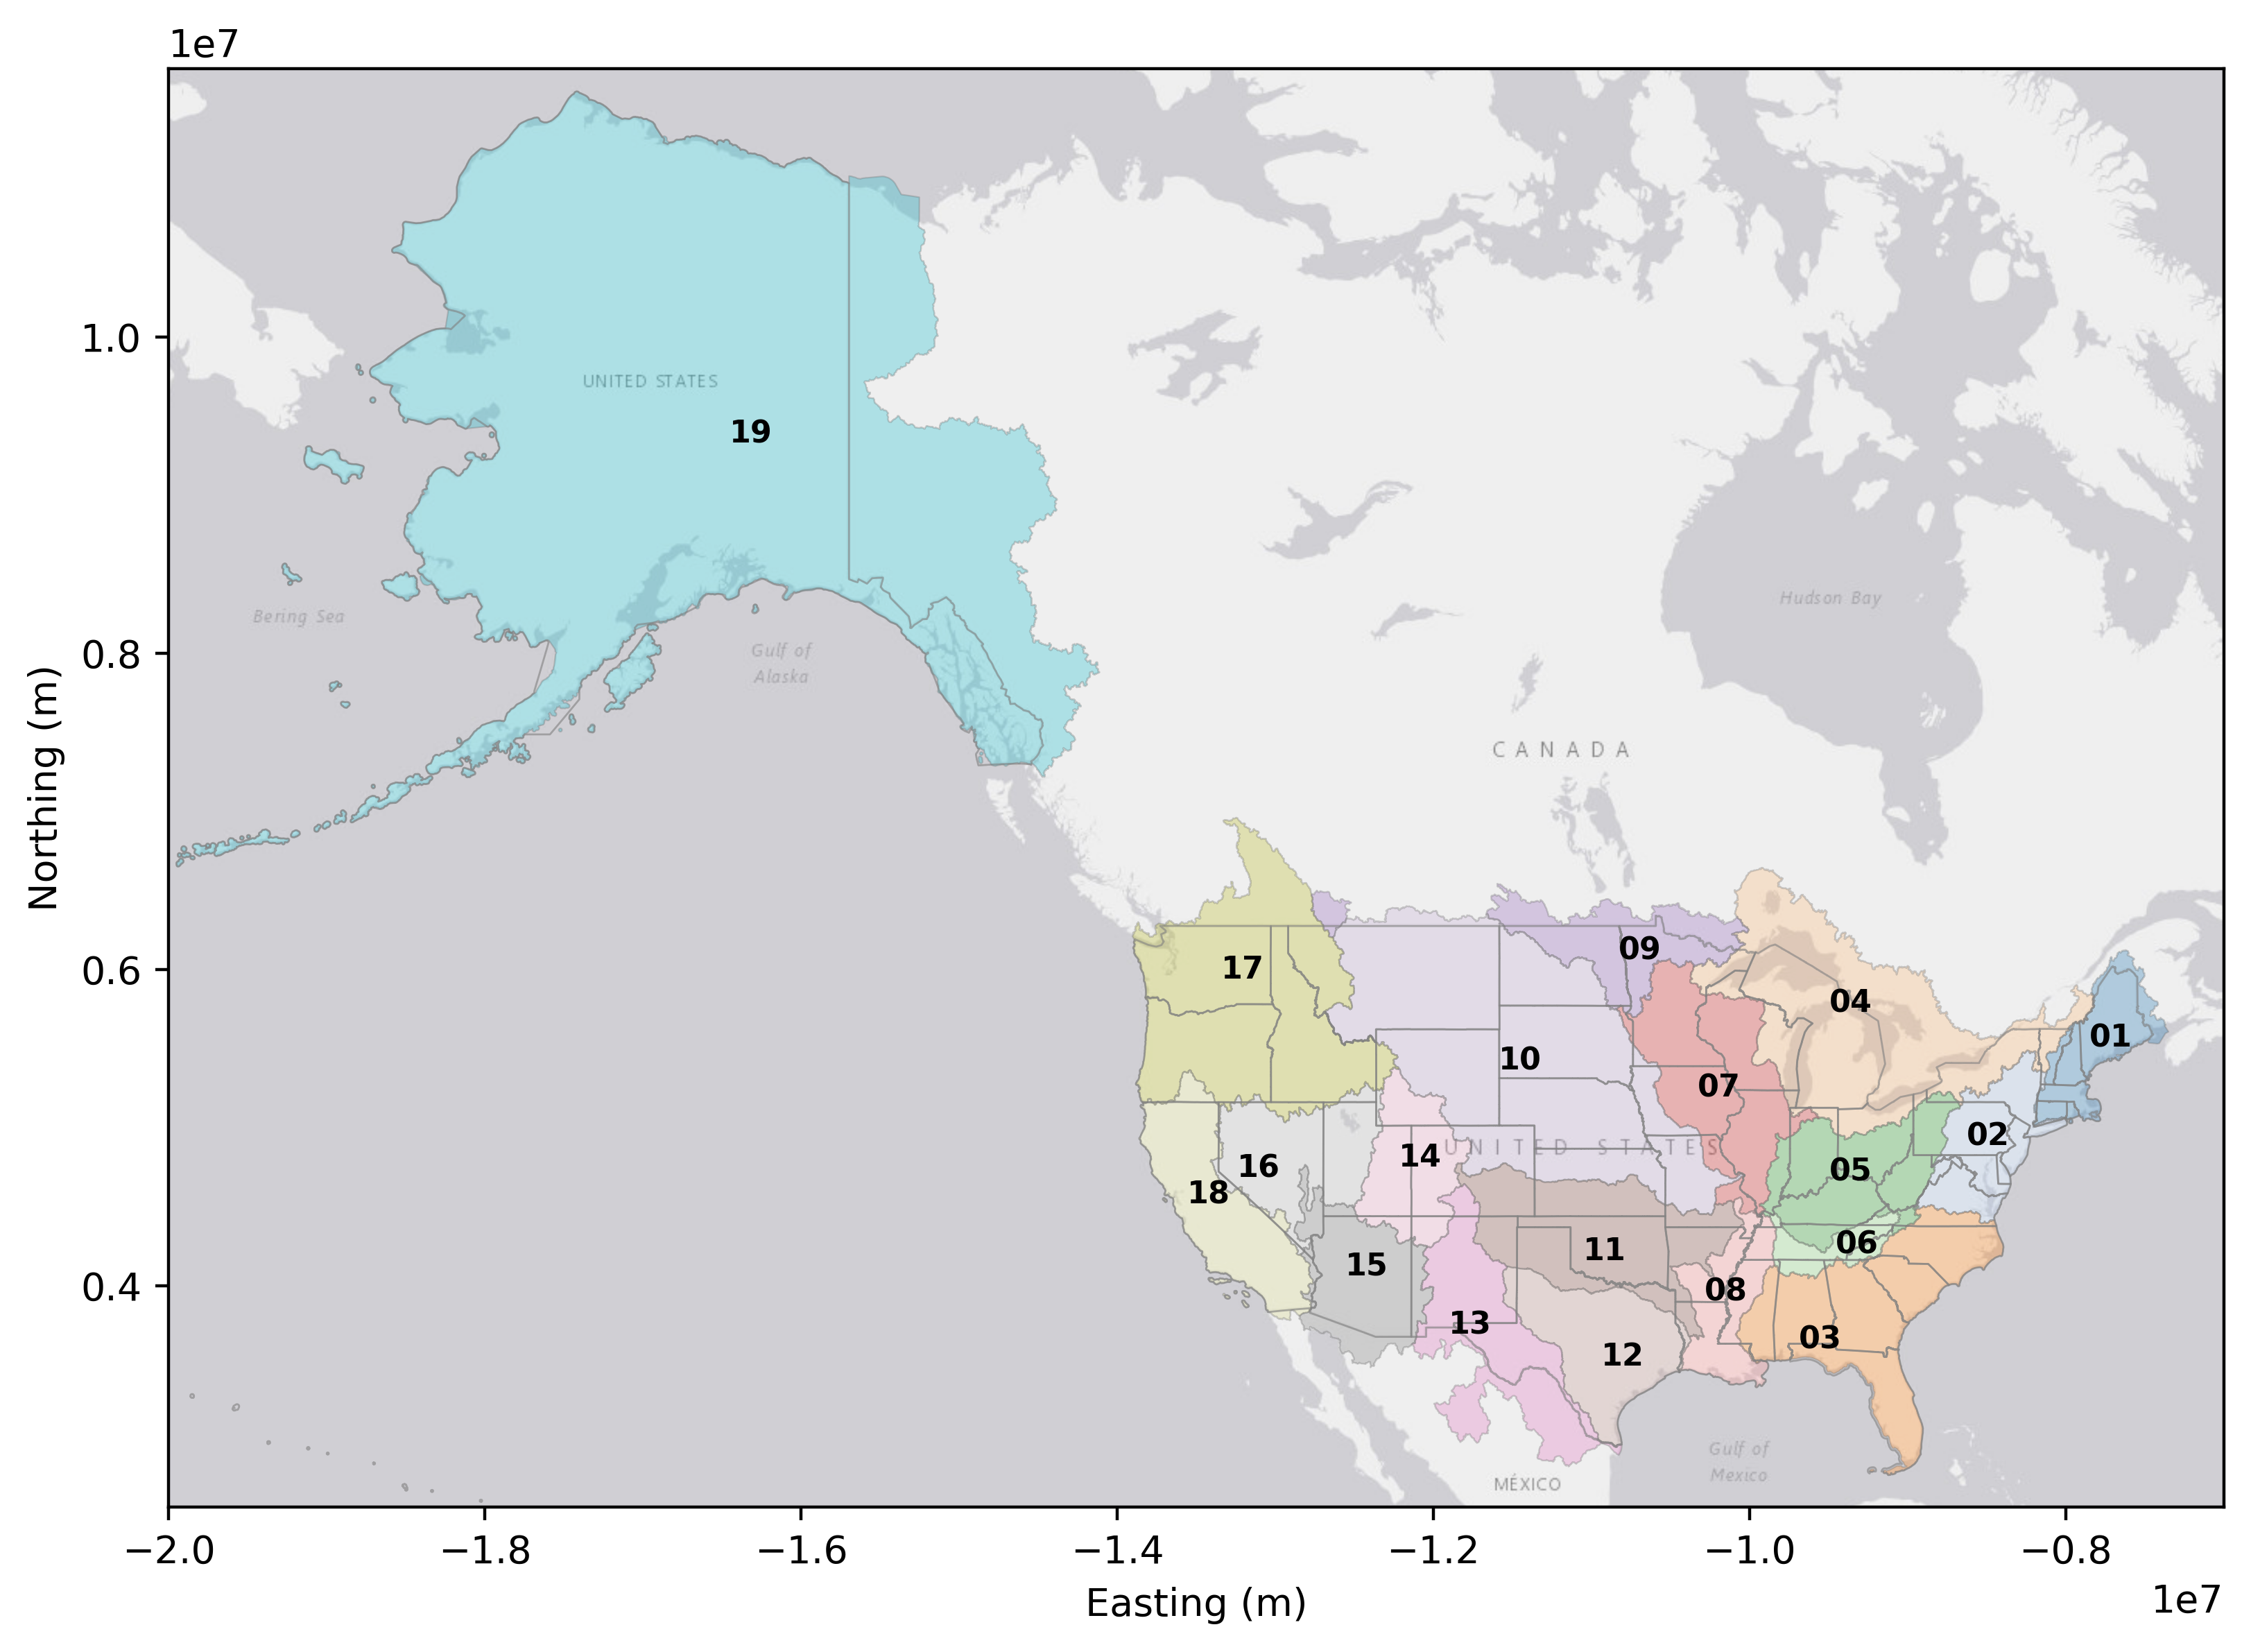

In [2]:
fig, ax = plot_hucs(
    base_dir="Examples/shapefiles/HUC_Zones",
    states_fp="Examples/shapefiles/US_STATES/tl_2023_us_state.shp",
    include_ak=True,
    figsize=(8, 6),
    basemap=True)


### Determine HUC zones
For this, we are interested in the HUC zones within the Mississippi River Basin (MSRB), so lets look in the CONUS.

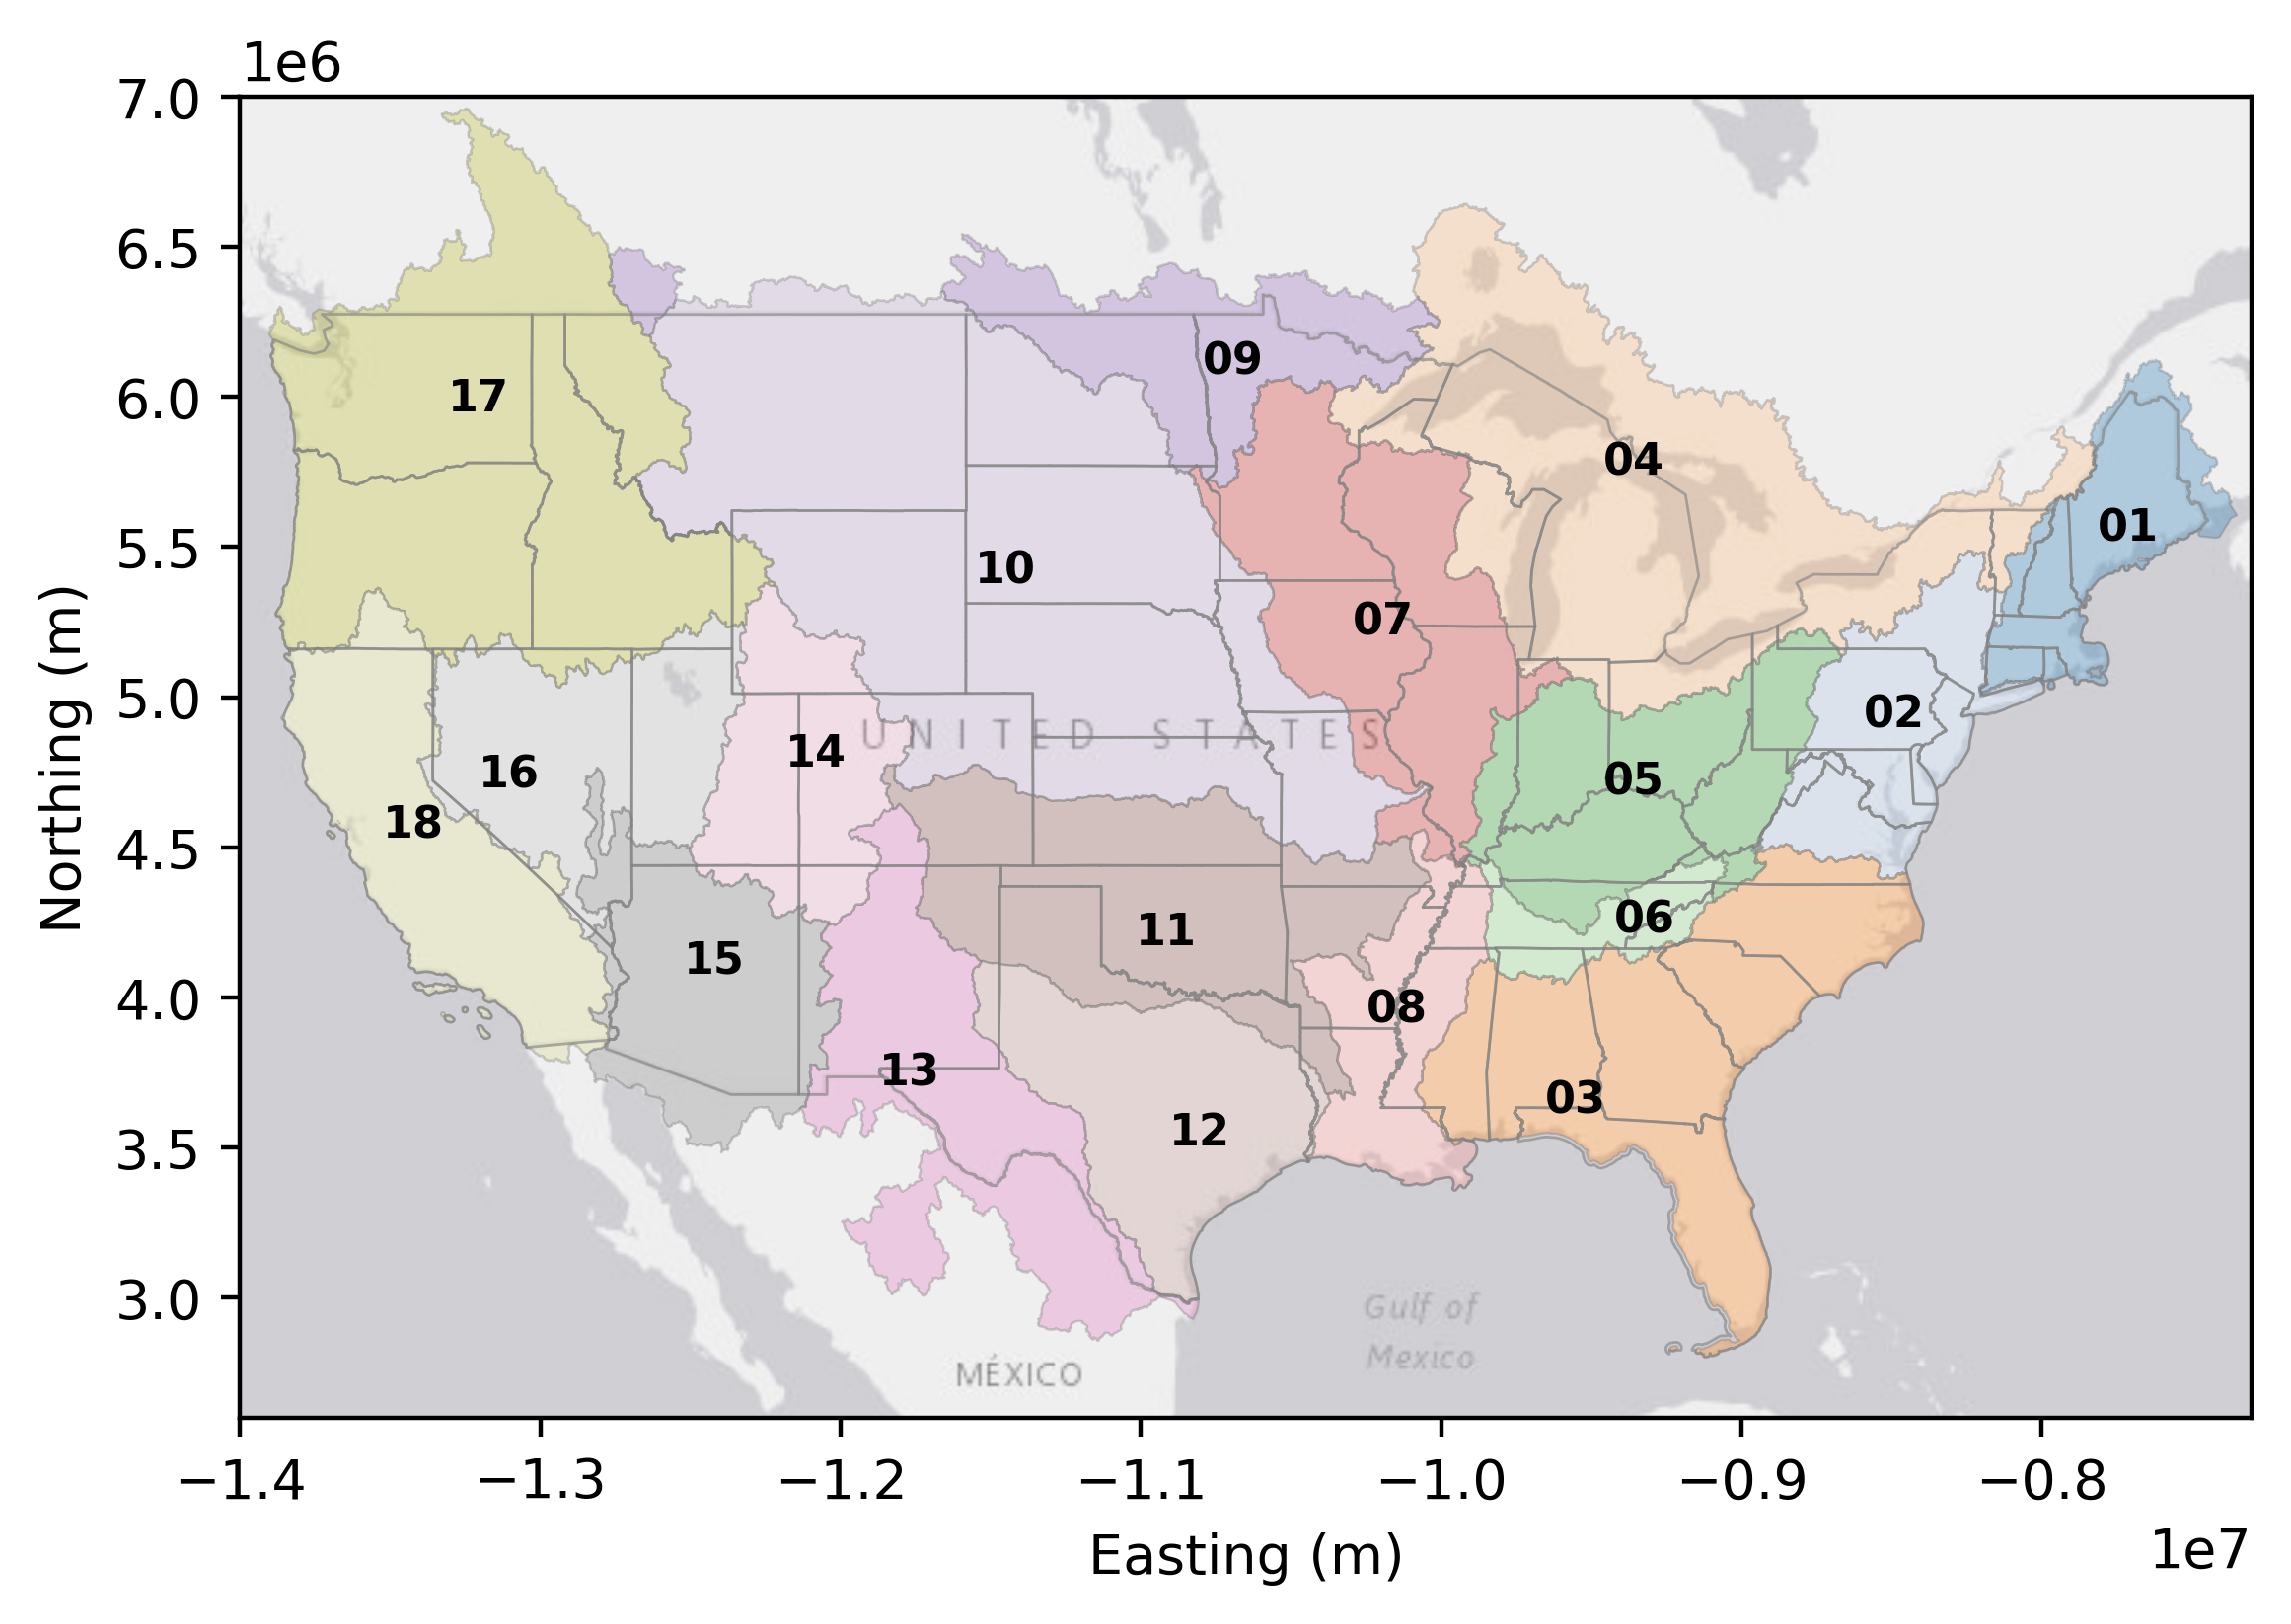

In [3]:
fig, ax = plot_hucs(base_dir="Examples/shapefiles/HUC_Zones", states_fp="Examples/shapefiles/US_STATES/tl_2023_us_state.shp",
    include_ak=False, figsize=(6, 4), basemap=True)


We want to see which HUC zones impact the MSR basin, so we are going to overlay the shape file of our basin on the figure we created above.

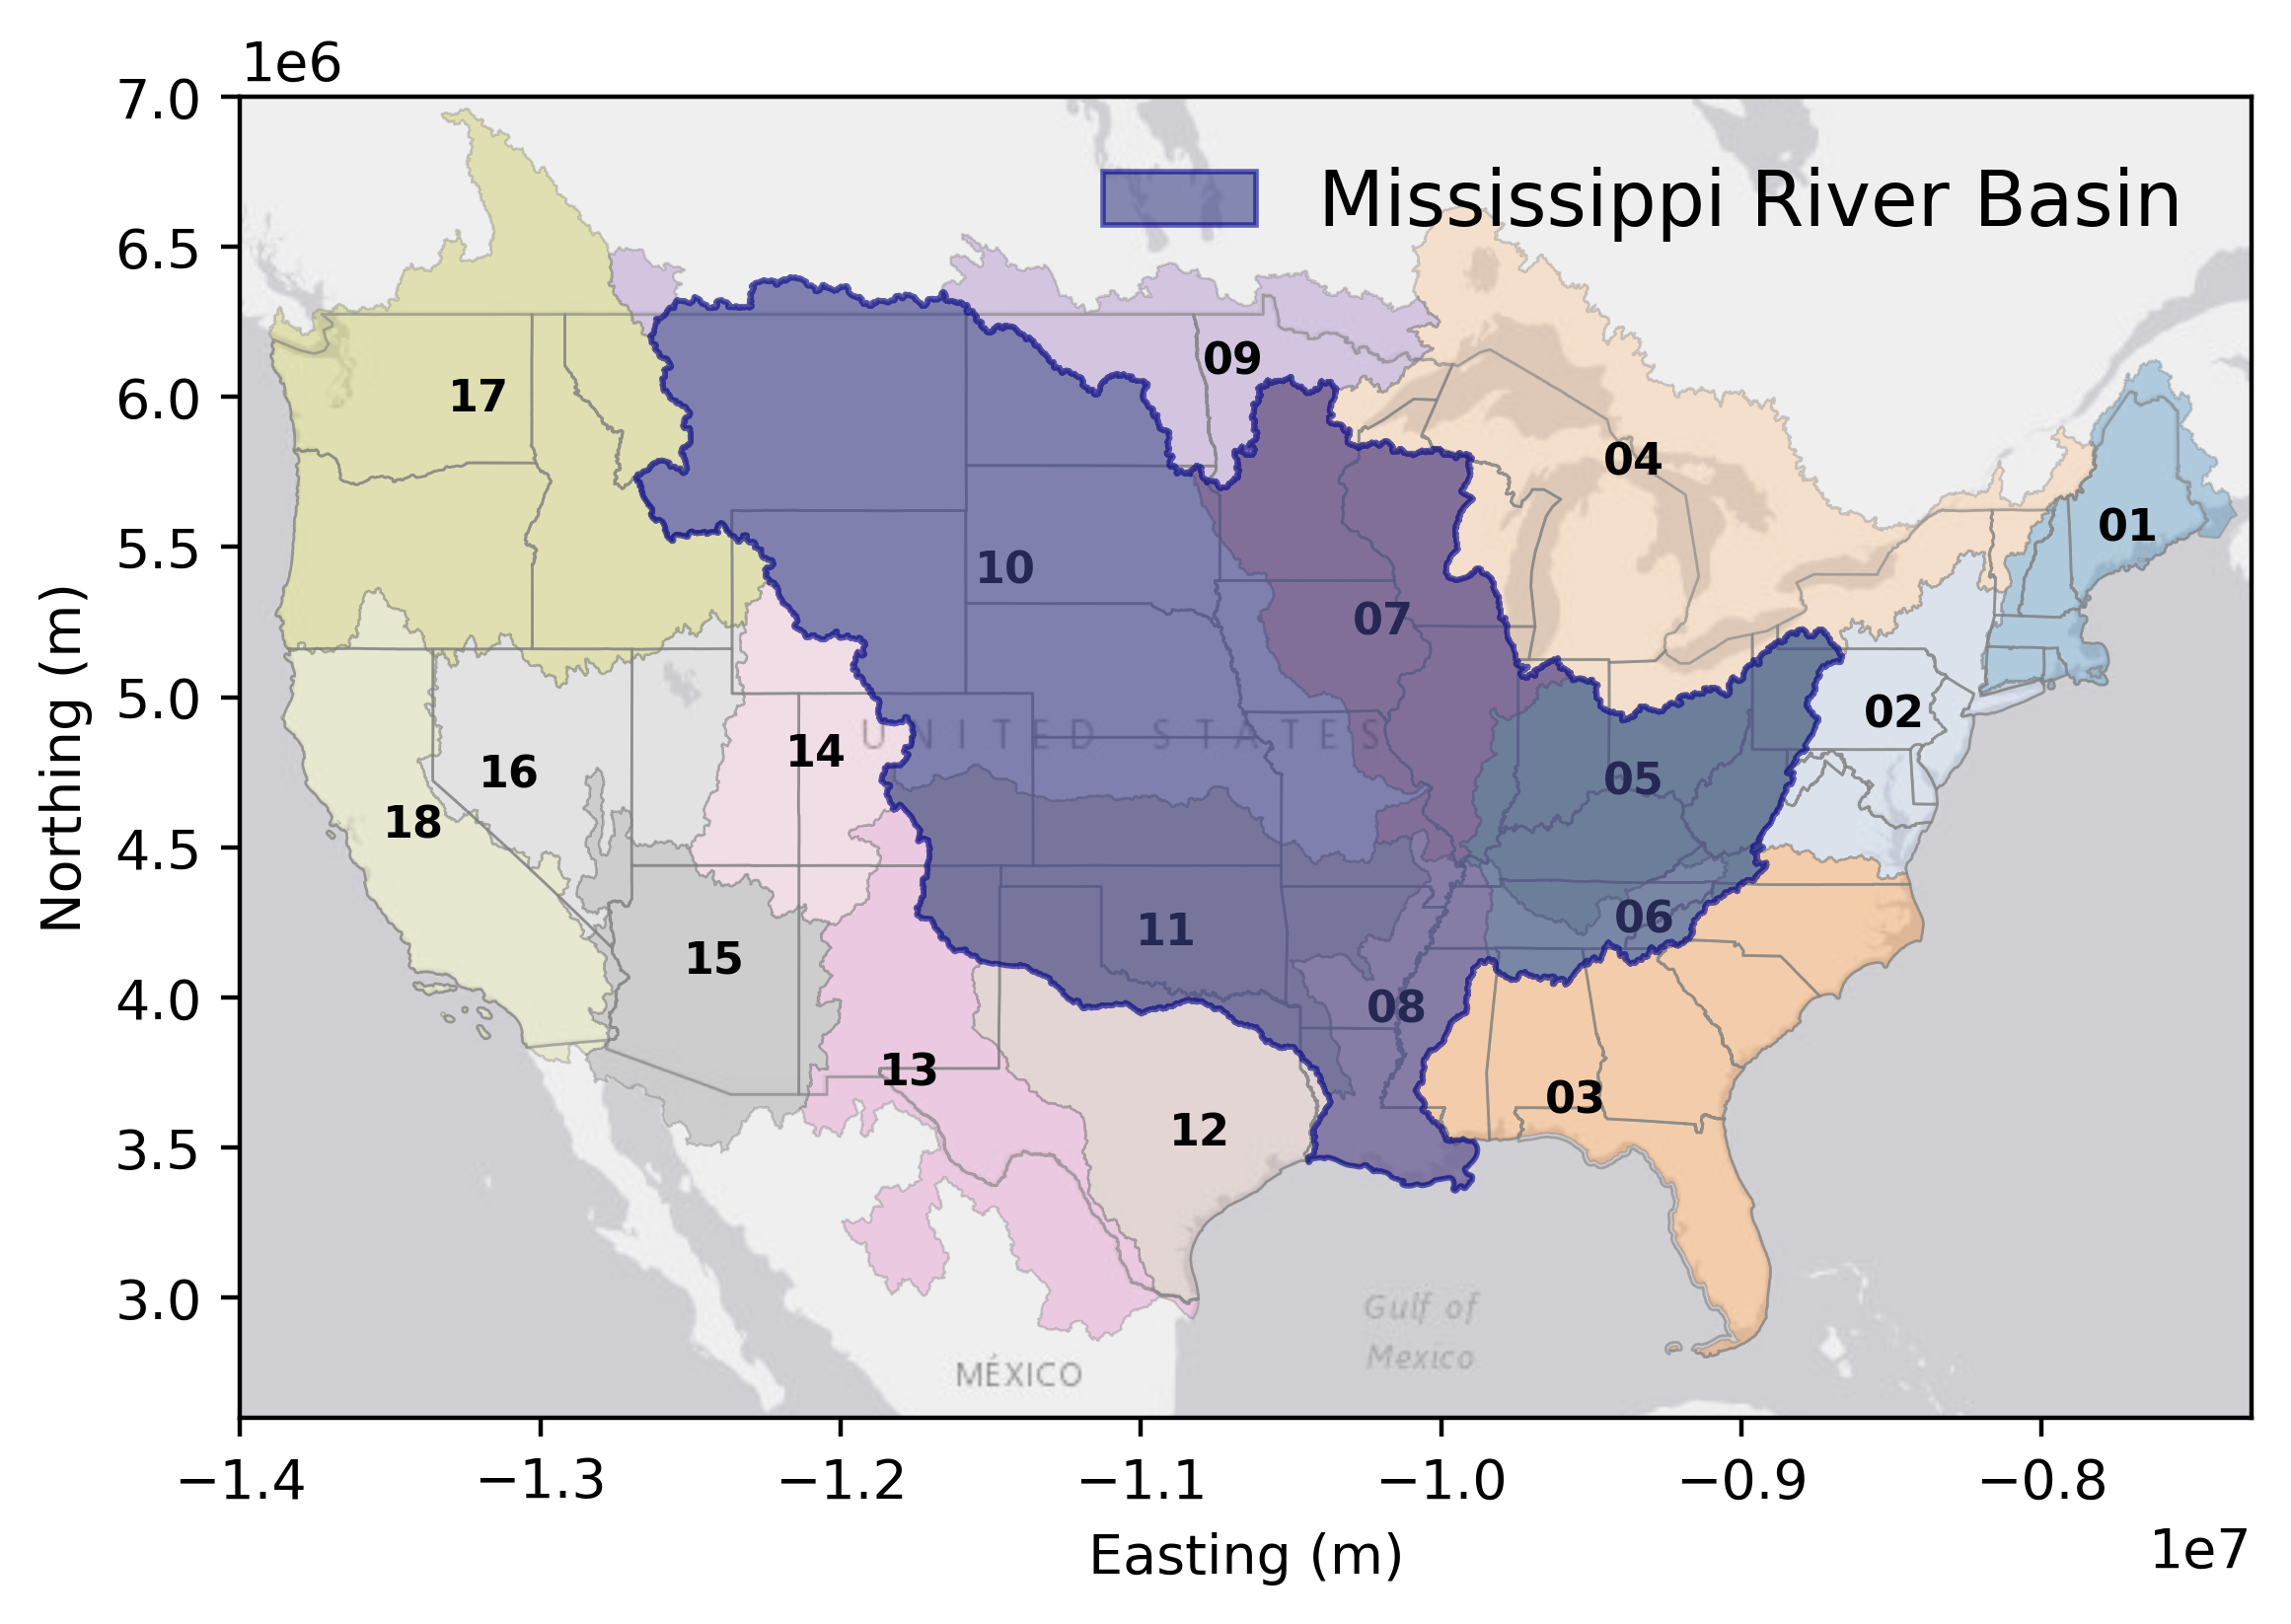

In [4]:
# Overlay basin on plot
fig, ax = plot_hucs(
    base_dir="Examples/shapefiles/HUC_Zones",
    states_fp="Examples/shapefiles/US_STATES/tl_2023_us_state.shp",
    include_ak=False,
    figsize=(6, 4),
    basemap=True)

basin = gpd.read_file("Examples/shapefiles/MSRB/Miss_RiverBasin.shp")
basin = basin if basin.crs.to_epsg() == 3857 else basin.to_crs(3857)
basin.plot(ax=ax, facecolor=cmocean.cm.ice(0.3), edgecolor="darkblue", alpha=0.6, zorder=4)
legend = ax.legend(handles=[mpatches.Patch(facecolor=cmocean.cm.ice(0.3), edgecolor="darkblue", alpha=0.6,
                            label="Mississippi River Basin")],frameon=False, fontsize=14)

We can see that the HUC zones 05, 06, 07, 08, 10, and 11 are within the Mississippi River Basin. We are additionally going to add HUC zones 04, 09, 14, and 17 due to their proximity to the basin. Discharge on the Mississippi River is influenced by snow melt. Zones 04, 09, 14, and 17 are where we can see this influence.

In [5]:
huc_codes = ["04", "05", "06", "07", "08", "09", "10", "11", "14", "17"]

We want to predict discharge. 

Select target gauge \
For this case, we are interested in Baton Rouge. \
Lets download and inspect this data.

We want to set start and end dates based on our target site's available data

Here we can choose what units we want

The options are `metric` and `customary`

Lets download the target site data

In [6]:
parameter = "discharge"
parameter_code = "00060"
target_site = "07374000"
start_date, end_date = "2005-01-02", "2024-12-31"

df = nwis.get_dv(sites=target_site, parameterCd=parameter_code,
                 start=start_date, end=end_date)[0]

target = df["00060_Mean"] * 0.0283168466
target.index = pd.to_datetime(target.index).tz_localize("UTC") if target.index.tz is None else target.index.tz_convert("UTC")

filled = (target.reindex(pd.date_range(start=start_date, end=end_date))
                .tz_localize("UTC")
                .interpolate(limit_direction="both")
                .ffill().bfill())

stats, s, v, q = compute_discharge_stats(target, start_date, end_date, tz="UTC")
fig, axes = plot_discharge_panels(s, v, q, opening_threshold=35400.0, y_max=46000, figsize=(7, 7), dpi=300)

Lets do some stats for the Target Site

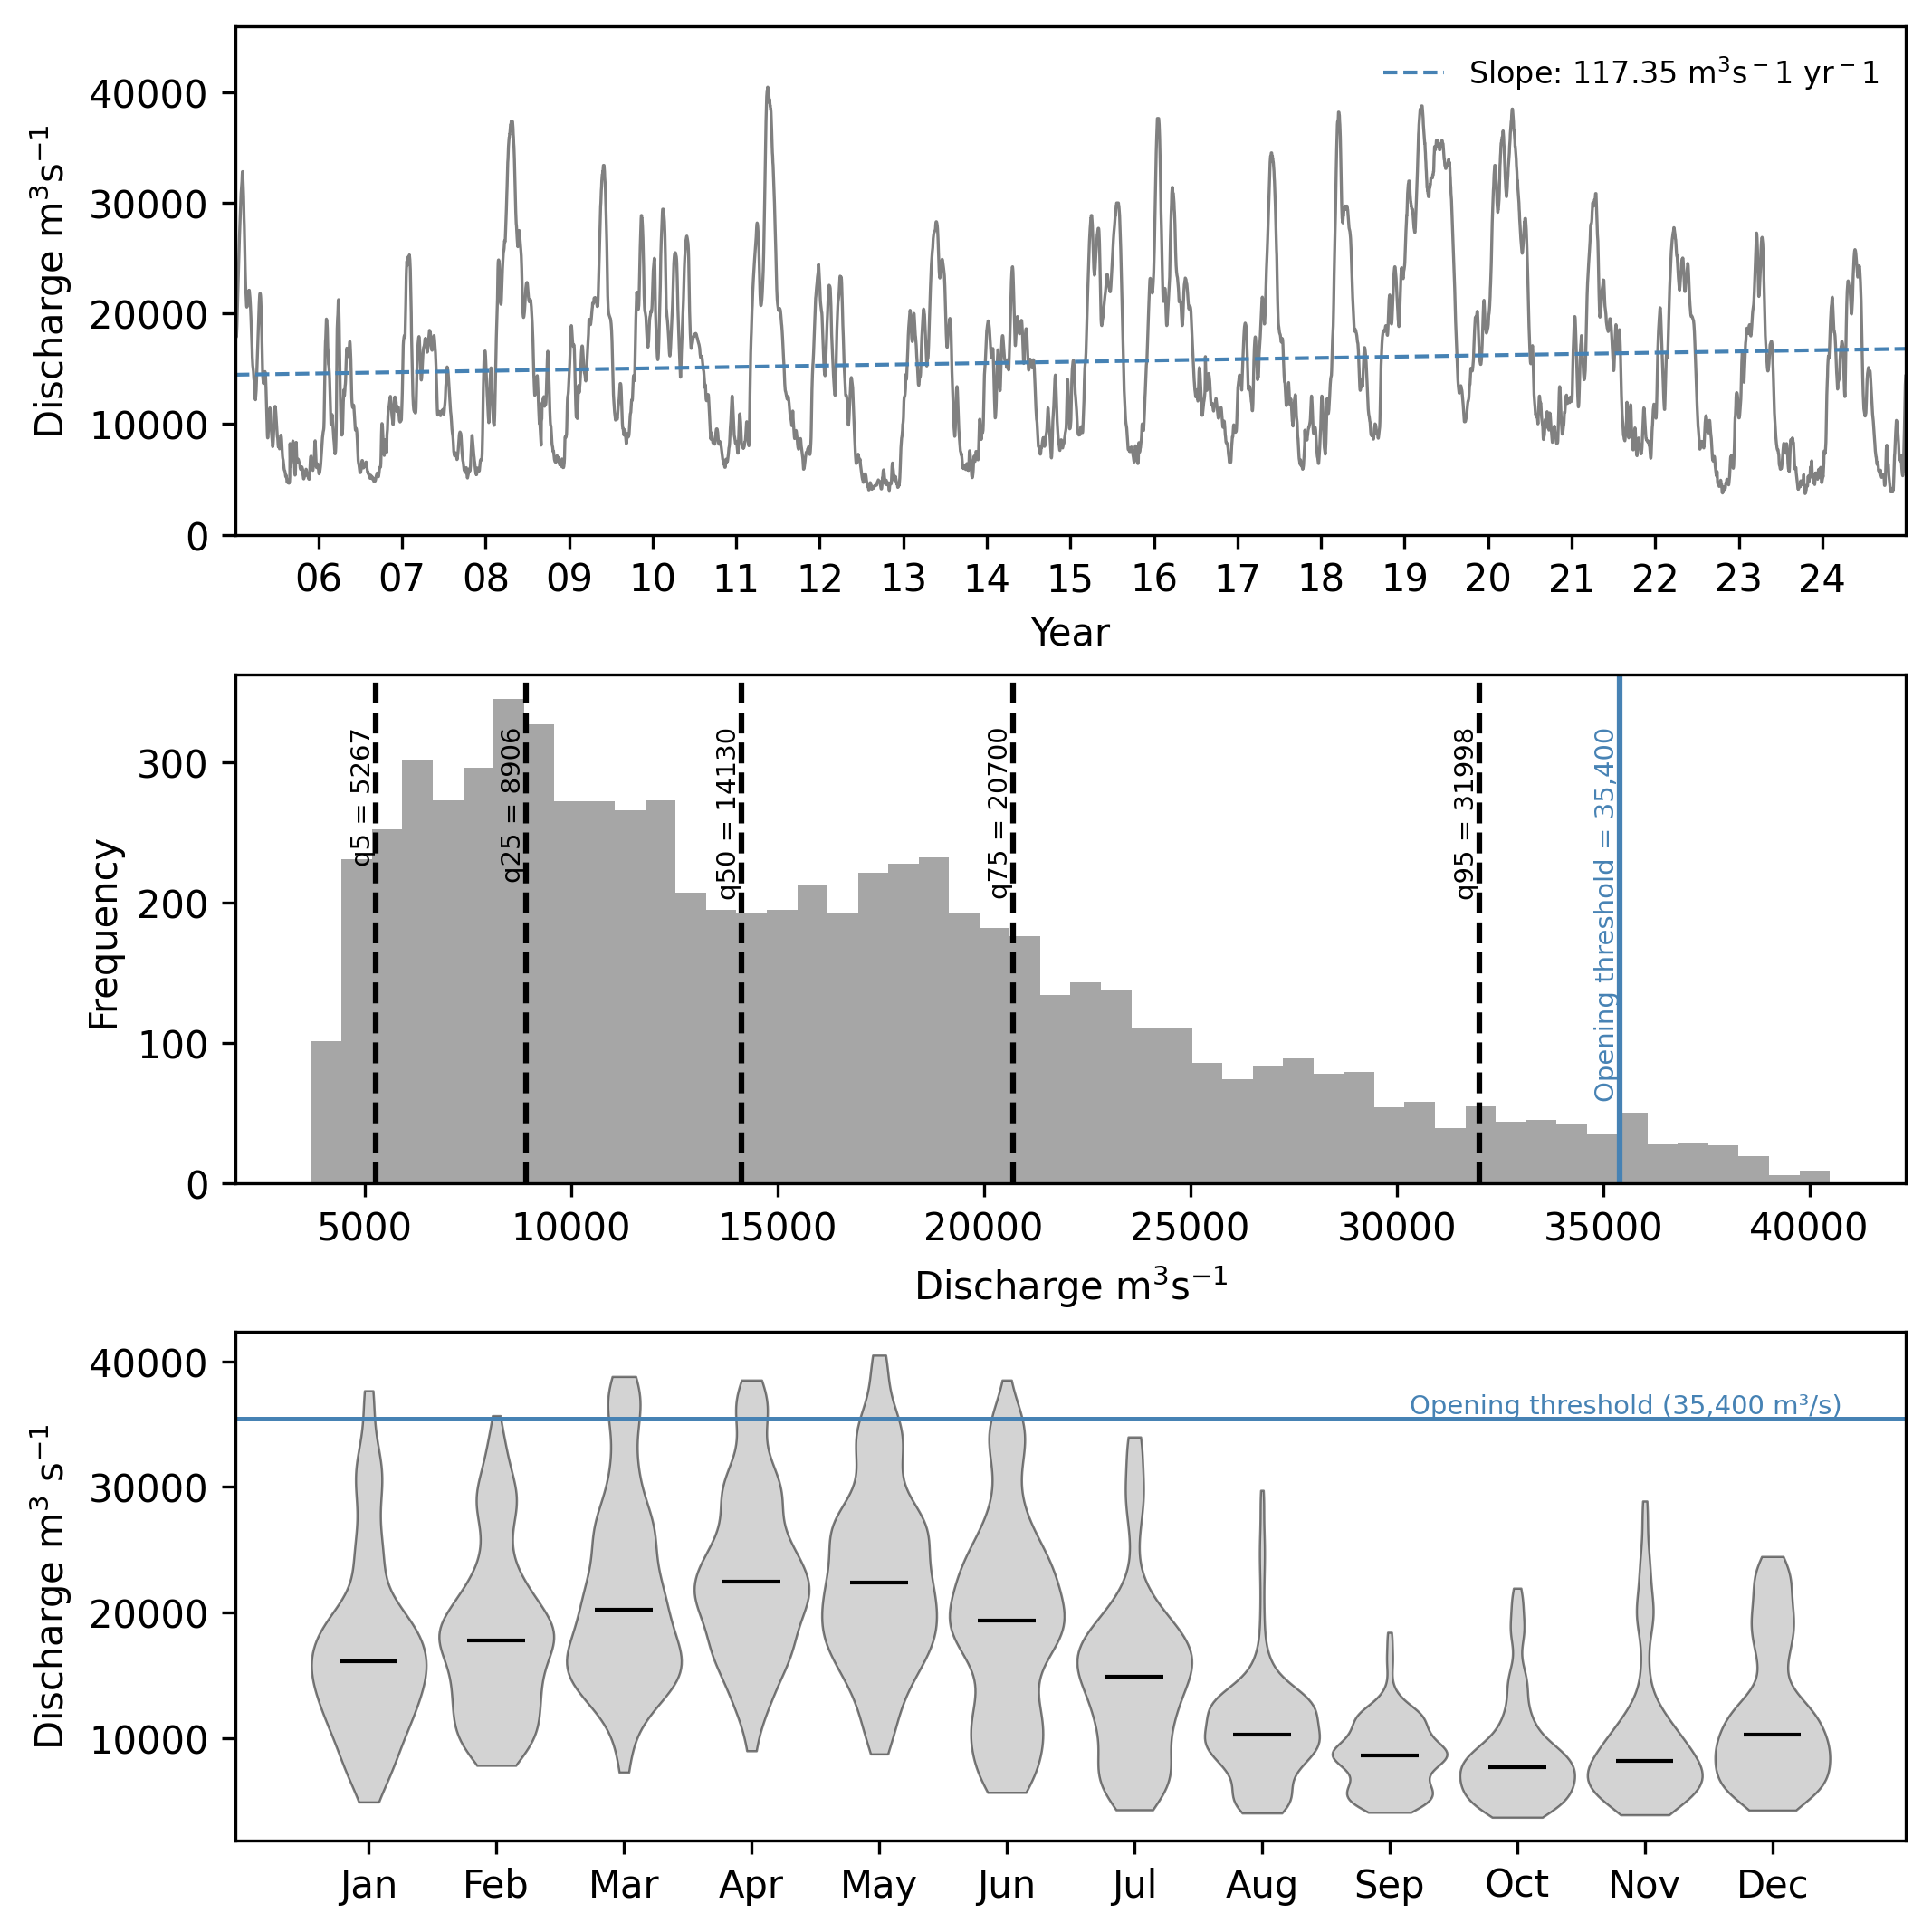

In [7]:
stats, s, v, q = compute_discharge_stats(target, start_date, end_date, tz="UTC")
fig, axes = plot_discharge_panels(s, v, q, opening_threshold=35400.0, y_max=46000, figsize=(7, 7), dpi=300)

Explain stats analysis of data for target site at Baton Rouge

We want this data to be as complete as possible. Here we are going to set a `percent_threshold`. We set this to `percent_threshold = 99`, meaning that the data set is 99% complete.

In [ ]:
percent_threshold = 99

Now we are going to set where we want the data to save to.

In [ ]:
data_dir = Path(f"cached_data_{parameter}")
json_path = data_dir / f"site_dict_{parameter}.json"

Download data. (This will get changed with a function)\
Explain what is happening to data set, inputs, outputs, etc.

We are going to predict discharge at our taret site with discharge data from the huc zones we selected
Other parameters can be entered. A list of parameters that USGS has can be found here {add}

This part of the code takes a while since we are scraping data.

In [ ]:
data_dir = Path(f"cached_data_{parameter}")
json_path = data_dir / f"site_dict_{parameter}.json"
#to_units = "metric"  
#paramter_code = "00060" 
#summary = GaugebyHUC(
#    start_date=start_date,
#    end_date=end_date,
#    huc_codes=huc_codes,
#    parameter_code=paramter_code, 
#    percent_threshold=percent_threshold,
#    data_dir=data_dir,
#    json_path=json_path,)

Import Data

In [ ]:
from pathlib import Path
import json
import pandas as pd

parameter = "discharge"
data_dir = Path(f"Examples/cached_data_{parameter}")
json_path = data_dir / f"site_dict_{parameter}.json"

# Load the site dictionary (metadata about cached sites)
with open(json_path, "r") as f:
    site_dict = json.load(f)



# If you want to summarize by HUC codes:
# This assumes GaugebyHUC reads from these same cached files,
# so you can call your function directly if you want a summary
# summary = GaugebyHUC(
#     start_date=start_date,
#     end_date=end_date,
#     huc_codes=huc_codes,
#     parameter_code="00060", 
#     percent_threshold=percent_threshold,
#     data_dir=data_dir,
#     json_path=json_path,
# )


CNN Model? Or put in second notebook

In [ ]:
# daily index
idx = build_full_index(start_date, end_date, tz="UTC")

# load json of candidate sites (whatever your generator produced)
raw = load_site_json(json_path )    

# build site series from json
site_series = build_site_series_from_json(raw, idx, parameter = parameter, to_units=to_units)

# fetch target site directly from nwis
target = load_target_series(
    target_site=target_site,
    start_date=start_date,
    end_date=end_date,
    parameter=parameter,
    to_units=to_units,
)

# assemble features
x_raw, y, names = stack_features(site_series, target)
x_raw.shape, y.shape, names[:5]